In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch # must include before mcas_gmra
import sys
from torchvision import datasets, transforms
from tqdm import tqdm
from scipy.spatial.distance import euclidean

sys.path.insert(0, '../..')

from src.covertree import CoverTree 
from src.dyadictree import DyadicTree, tree_traverse
from src.wavelettree import WaveletTree
from src.utils import *




import os
import torch

if not os.path.exists('../../datasets/alliya_image_denoise'):
    !git clone https://github.com/parvezalliya/imgdenoisforcancdetc.git ../../datasets/alliya_image_denoise
else:
    print("Directory already exists.")

Directory already exists.


In [2]:
# load alliya_image_denoise/dataset/raw_endoscopic_scans/*.tiff
import os
import glob

img_path = glob.glob('../../datasets/alliya_image_denoise/dataset/raw_endoscopic_scans/*PMT1.tiff')
# sort
img_path.sort()


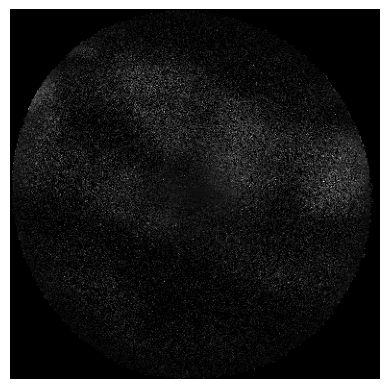

In [3]:
# show 1 tiff image in the folder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
def show_tiff_image(img_path):
    img = Image.open(img_path)
    img = np.array(img)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
# show 1 tiff image
show_tiff_image(img_path[0])

def load_tiffs_to_numpy(imgs):
    # load tiff to (N,C,H,W)
    img_list = []
    for img_path in imgs:
        img = Image.open(img_path)
        img = np.array(img)
        img_list.append(img)
    img_list = torch.tensor(img_list)
    # convert to (N,C,H,W)
    # img_list = np.transpose(img_list, (0, 3, 1, 2))
    img_list = img_list.unsqueeze(1).float()
    return img_list

In [4]:
imgs = load_tiffs_to_numpy(img_path)

/tmp/ipykernel_1488553/2408450336.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img_list = torch.tensor(img_list)


In [5]:
# normalize with torch vision transform
import torchvision.transforms as transforms
import torchvision

In [6]:
imgs[0].max()

tensor(65535.)

In [7]:
# imgs is a 4D torch.Tensor containing the loaded TIFF images.
# Its shape is (N, C, H, W), where:
# N = number of images (30 in your case)
# C = number of channels (1, since grayscale)
# H, W = height and width of each image
# The dtype is torch.uint16, matching the original TIFF image bit depth.
# Each entry in imgs[n, 0, :, :] is the pixel data for the nth image.
print(f"imgs shape: {imgs.shape}, dtype: {imgs.dtype}")
print(f"First image path: {img_path[0]}")

imgs shape: torch.Size([30, 1, 385, 385]), dtype: torch.float32
First image path: ../../datasets/alliya_image_denoise/dataset/raw_endoscopic_scans/Image-20250326-231205-592-PMT1.tiff


torch.Size([30, 1, 385, 385])

In [8]:
X = imgs
if type(X) is not torch.Tensor:
    X = torch.from_numpy(X).float()
# make dim 2 if not
if len(X.shape) != 2:
    X = X.reshape(X.shape[0], -1)


In [9]:
python_covertree =  CoverTree(X, euclidean, leafsize=1)
mydiadic_tree    =  DyadicTree(python_covertree)
wavelet_tree = WaveletTree(mydiadic_tree, X, 0, X.shape[-1], inverse=True,
                           thresholds=.1) # inverse means data in (n,d) formatdj

wavelet_tree.make_wavelets(X)

info: making wavelet tree
info: making wavelets
info: making transforms at level 3
info: making transforms at level 2
info: making transforms at level 1
info: making transforms at level 0


In [10]:
X = X.numpy()
def my_fgwt(wavelet_tree, X):
    J = depth(wavelet_tree.root)
    leafs = get_leafs(wavelet_tree.root)

    Qjx = [None] * X.shape[0]
    max_lvl = 0
    for leaf in leafs:
        data_idx  = int(leaf.idxs[0])
        # print(int(data_idx))

        pjx = leaf.basis @ (X[data_idx:data_idx+1,:].T-leaf.center)
        qjx = leaf.wav_basis  @ leaf.basis.T @ pjx
        Qjx[data_idx]=[qjx]

        pJx = pjx
        
        p = path(leaf)

        # pjx = pJx
        # ct = 0
        lvl_counter = len(p)
        # print('lvl_counter', lvl_counter)   
        # print('lvl_counter', lvl_counter)
        for n in reversed(p[1:-1]):
            pjx = n.basis @ leaf.basis.T @ pJx + \
                    n.basis @ ( leaf.center - n.center ) 
            # print(n.wav_basis.shape, n.basis.T.shape, pjx.shape)
            qjx = n.wav_basis @ n.basis.T @ pjx
            Qjx[data_idx].append(qjx)
            # print('a')
            # lvl_counter-=1
            # print('done', lvl_counter)
            # pJx = pJx + p.basis @ (p.center - p.parent.center)
            # print(qjx.shape)
        n = p[0]
        pjx = n.basis @ leaf.basis.T @ pJx + n.basis @ ( leaf.center - n.center ) 
        qjx = pjx
        Qjx[data_idx].append(qjx)
        Qjx[data_idx] = list(reversed(Qjx[data_idx]))
    return Qjx

gmra_q_coeff = my_fgwt(wavelet_tree, X)



In [11]:
gmra_q_coeff[1]


[array([[-436916.78  ],
        [-692745.6   ],
        [   6703.3403],
        [ -12637.336 ],
        [ 529333.25  ],
        [-766826.75  ],
        [  68674.84  ],
        [ -90768.81  ],
        [ 733614.7   ],
        [  60309.34  ],
        [ 505193.22  ],
        [  22921.156 ],
        [  57580.27  ],
        [  53185.277 ],
        [   7175.4766]], dtype=float32),
 array([[  2130.5781],
        [548689.    ]], dtype=float32),
 array([], shape=(0, 1), dtype=float64)]

In [12]:
def my_igwt(wavelet_tree, gmra_q_coeff):
    J_max = depth(wavelet_tree.root)

    X_recon = np.zeros_like(X)
    # idx_reconstructed  = []
    for leaf in tqdm(get_leafs(wavelet_tree.root)):
        data_idx  = leaf.idxs[0]
        # print('reconstructing', data_idx)
        # idx_reconstructed.append(data_idx)
        # print('data_idx', data_idx)
        chain = path(leaf)
        
        ct=-1

        Qjx = leaf.wav_basis.T @ gmra_q_coeff[data_idx][ct] + leaf.wav_consts

        new_chain = chain[1:-1]
        for jj, n in reversed(list(enumerate(new_chain))):
            # print(len(gmra_q_coeff[data_idx]))
            ct-=1
            Qjx += (n.wav_basis.T @ gmra_q_coeff[data_idx][ct] + n.wav_consts +
                    new_chain[jj-1].basis.T @ new_chain[jj-1].basis @ Qjx)
            # print(ct)
        ct-=1
        Qjx += chain[0].basis.T@ gmra_q_coeff[data_idx][ct] + chain[0].center 
        X_recon[data_idx:data_idx+1,:] = Qjx.T
    return X_recon
        
X_recon  = my_igwt(wavelet_tree, gmra_q_coeff)   
#

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [21:12<00:00, 42.40s/it]


In [13]:
print(X_recon.shape)

(30, 148225)


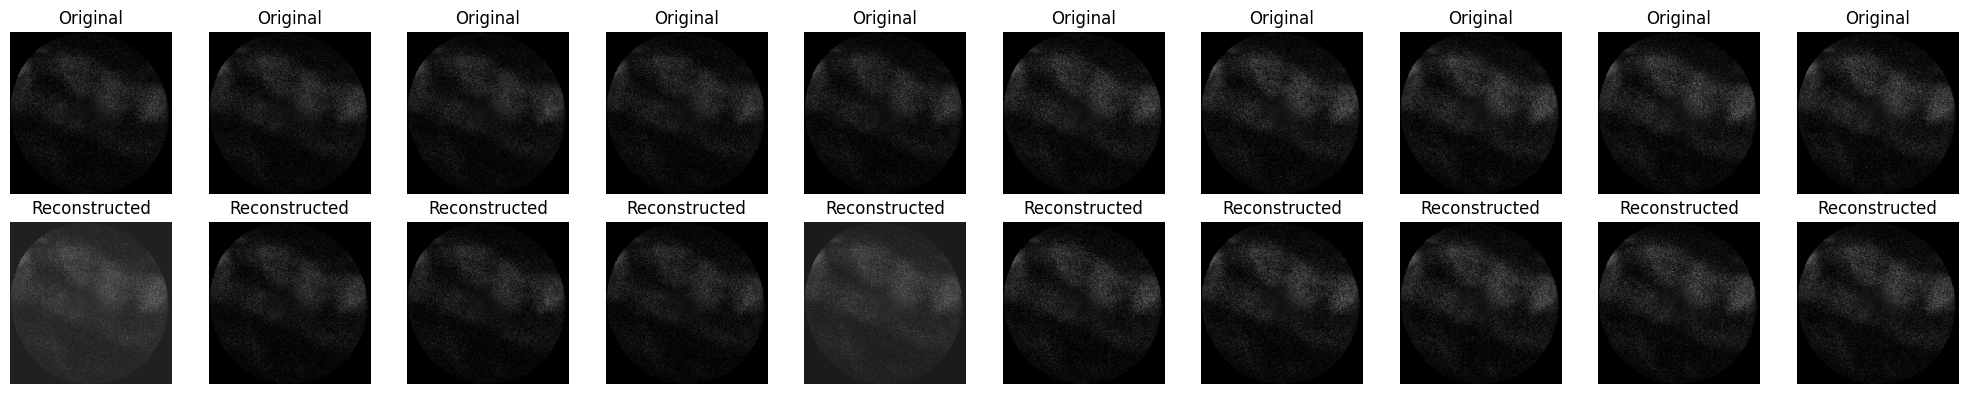

In [16]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0, i].imshow(X[i].reshape(385, 385), cmap='gray')
    ax[0, i].set_title("Original")
    ax[0, i].axis('off')
    ax[1, i].imshow(X_recon[i].reshape(385, 385), cmap='gray')
    ax[1, i].set_title("Reconstructed")
    ax[1, i].axis('off')
plt.tight_layout()
plt.show()


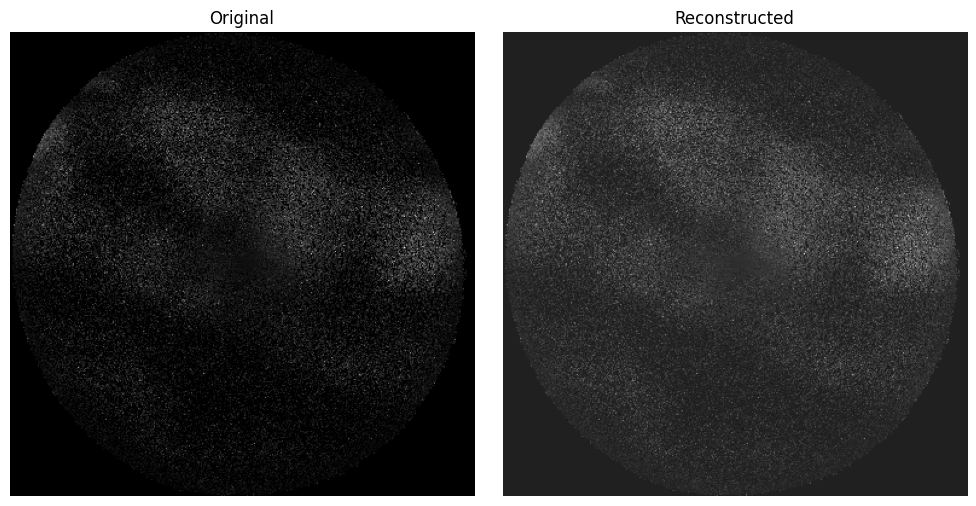

In [17]:
# show X vs X_recon for img index
idx = 0 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(X[idx].reshape(385, 385), cmap='gray')
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(X_recon[idx].reshape(385, 385), cmap='gray')
ax[1].set_title("Reconstructed")
ax[1].axis('off')
plt.tight_layout()
plt.show()